In [1]:
import os
import sys
import json
import copy
import numpy as np
from rodeo import RoDeO
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

CODEBASE_DIR = Path().resolve().parent
sys.path.append(str(CODEBASE_DIR))

from src.calculate_map import compute_map_supervision, draw_boxes, draw_boxes_on_image

d:\TUM\AI_in_VLM\code\code\vlm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Chest Xrays

In [2]:
true_annotations_path = CODEBASE_DIR / "data/chest_xrays/annotations_len_50.json"
detection_annotations_path = CODEBASE_DIR / "data/chest_xrays/detection_annotation_results.json"
classification_annotations_path = CODEBASE_DIR / "data/chest_xrays/classification_annotation_results.json"

In [ ]:
with open(true_annotations_path, 'r') as file:
    true_annotations = json.load(file)

with open(detection_annotations_path, 'r') as file:
    detection_annotations = json.load(file)

annotations_list = []
classes_labels = []

for obj in detection_annotations:
    classes_labels.extend([ele[-1] for ele in true_annotations[obj["imageID"]]["bbox_2d"]])
    annotations_list.append(
        {
            "imageID": obj["imageID"],
            "true_boxes": [ele[:-1] for ele in true_annotations[obj["imageID"]]["bbox_2d"]],
            "true_classes": [ele[-1] for ele in true_annotations[obj["imageID"]]["bbox_2d"]],
            "detected_boxes": [[ele["box_2d"][1], ele["box_2d"][0], ele["box_2d"][3], ele["box_2d"][2]] for ele in obj["annotation"]],
            "detected_classes": [ele["label"] for ele in obj["annotation"]]
        }
    )

classes_labels = list(set(classes_labels))
classes_labels = sorted(classes_labels)
classes_labels_map = {}
for idx, label in enumerate(classes_labels):
    classes_labels_map[label.lower()] = idx

In [4]:
classes_labels_map

{'aortic enlargement': 0,
 'calcification': 1,
 'cardiomegaly': 2,
 'consolidation': 3,
 'emphysema': 4,
 'ild': 5,
 'infiltration': 6,
 'lung opacity': 7,
 'lung cyst': 8,
 'mass': 9,
 'other lesion': 10,
 'pleural effusion': 11,
 'pleural thickening': 12,
 'pneumothorax': 13,
 'pulmonary fibrosis': 14,
 'rib fracture': 15}

In [ ]:
# for Rodeo metrics
rodeo_annotations_list = copy.deepcopy(annotations_list)

for obj in rodeo_annotations_list:
    if len(obj["true_boxes"])>0:
        for idx, ele in enumerate(obj["true_boxes"]):
            ele.append(classes_labels_map[obj["true_classes"][idx].lower()])
    else:
        obj["true_boxes"] = [[]]

    if len(obj["detected_boxes"])>0:
        for idx, ele in enumerate(obj["detected_boxes"]):
            ele.append(classes_labels_map[obj["detected_classes"][idx].lower()])
    else:
        obj["detected_boxes"] = [[]]

In [27]:
rodeo = RoDeO(class_names=classes_labels_map.keys())

true_boxes = []
detected_boxes = []
for obj in rodeo_annotations_list:
    tb = np.array(obj["true_boxes"], dtype=np.float32)
    db = np.array(obj["detected_boxes"], dtype=np.float32)
    tb = tb.reshape(-1, 5) if tb.size > 0 else np.empty((0, 5), dtype=np.float32)
    db = db.reshape(-1, 5) if db.size > 0 else np.empty((0, 5), dtype=np.float32)

    true_boxes.append(tb)
    detected_boxes.append(db)

rodeo.add(detected_boxes, true_boxes)
score = rodeo.compute()

for k, v in score.items():
    print(f"{k}: {v:.5f}")

RoDeO/localization: 0.09350
RoDeO/shape_matching: 0.07201
RoDeO/classification: 0.03260
RoDeO/total: 0.05429


In [22]:
diseases_classes = []
for key, value in true_annotations.items():
    for disease in value["bbox_2d"]:
        diseases_classes.append(disease[4])

diseases_classes = sorted(list(set(diseases_classes)))

disease_label_map = {name.lower(): idx for idx, name in enumerate(diseases_classes)}
label_to_disease = {idx: name.lower() for name, idx in disease_label_map.items()}


In [ ]:
os.makedirs(CODEBASE_DIR / f"data/chest_xrays/comparison_images", exist_ok=True)

map50_95 = []
map50 = []
map75 = []

for idx in range(len(annotations_list)):
    image_path = CODEBASE_DIR / f"data/chest_xrays/images/{annotations_list[idx]['imageID']}.png"
    save_path = CODEBASE_DIR / f"data/chest_xrays/comparison_images/{annotations_list[idx]['imageID']}.png"

    pred_boxes = annotations_list[idx]["detected_boxes"]
    true_boxes = annotations_list[idx]["true_boxes"]

    pred_classes = [disease_label_map[name.lower()] for name in annotations_list[idx]["detected_classes"]]
    true_classes = [disease_label_map[name.lower()] for name in annotations_list[idx]["true_classes"]]

    result = compute_map_supervision(pred_boxes, pred_classes, true_boxes, true_classes)

    # draw_boxes(pred_boxes, true_boxes, image_size=(1024, 1024))
    draw_boxes_on_image(
        image_path=image_path, 
        pred_boxes=pred_boxes, 
        true_boxes=true_boxes, 
        pred_labels=annotations_list[idx]["detected_classes"], 
        true_labels=annotations_list[idx]["true_classes"], 
        save_path=save_path
    )

    annotations_list[idx]["mAP@50:95:"] = result.map50_95
    annotations_list[idx]["mAP@50:"] = result.map50
    annotations_list[idx]["mAP@75:"] = result.map75

    map50_95.append(result.map50_95)
    map50.append(result.map50)
    map75.append(result.map75)

print(f"mAP@50:95: {(sum(map50_95) / len(map50_95)):.5f}")
print(f"mAP@50: {(sum(map50) / len(map50)):.5f}")
print(f"mAP@75: {(sum(map75) / len(map75)):.5f}")

mAP@50:95: 0.00000
mAP@50: 0.00000
mAP@75: 0.00000


In [47]:
print(sorted(map50_95, reverse=True))
print(sorted(map50, reverse=True))
print(sorted(map75, reverse=True))

[np.float32(0.0), np.float64(0.0), np.float32(0.0), np.float32(0.0), np.float64(0.0), np.float64(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float64(0.0), np.float32(0.0), np.float64(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float64(0.0), np.float32(0.0), np.float32(0.0), np.float64(0.0), np.float32(0.0), np.float64(0.0), np.float64(0.0), np.float32(0.0), np.float32(0.0), np.float64(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float64(0.0), np.float32(0.0), np.float64(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)]
[np.float32(0.0), np.float64(0.0), np.float32(0.0), np.float32(0.0), np.float64(0.0), np.float64(0.0), np.float32(0.0), np.float32(0.0), np.float32(0

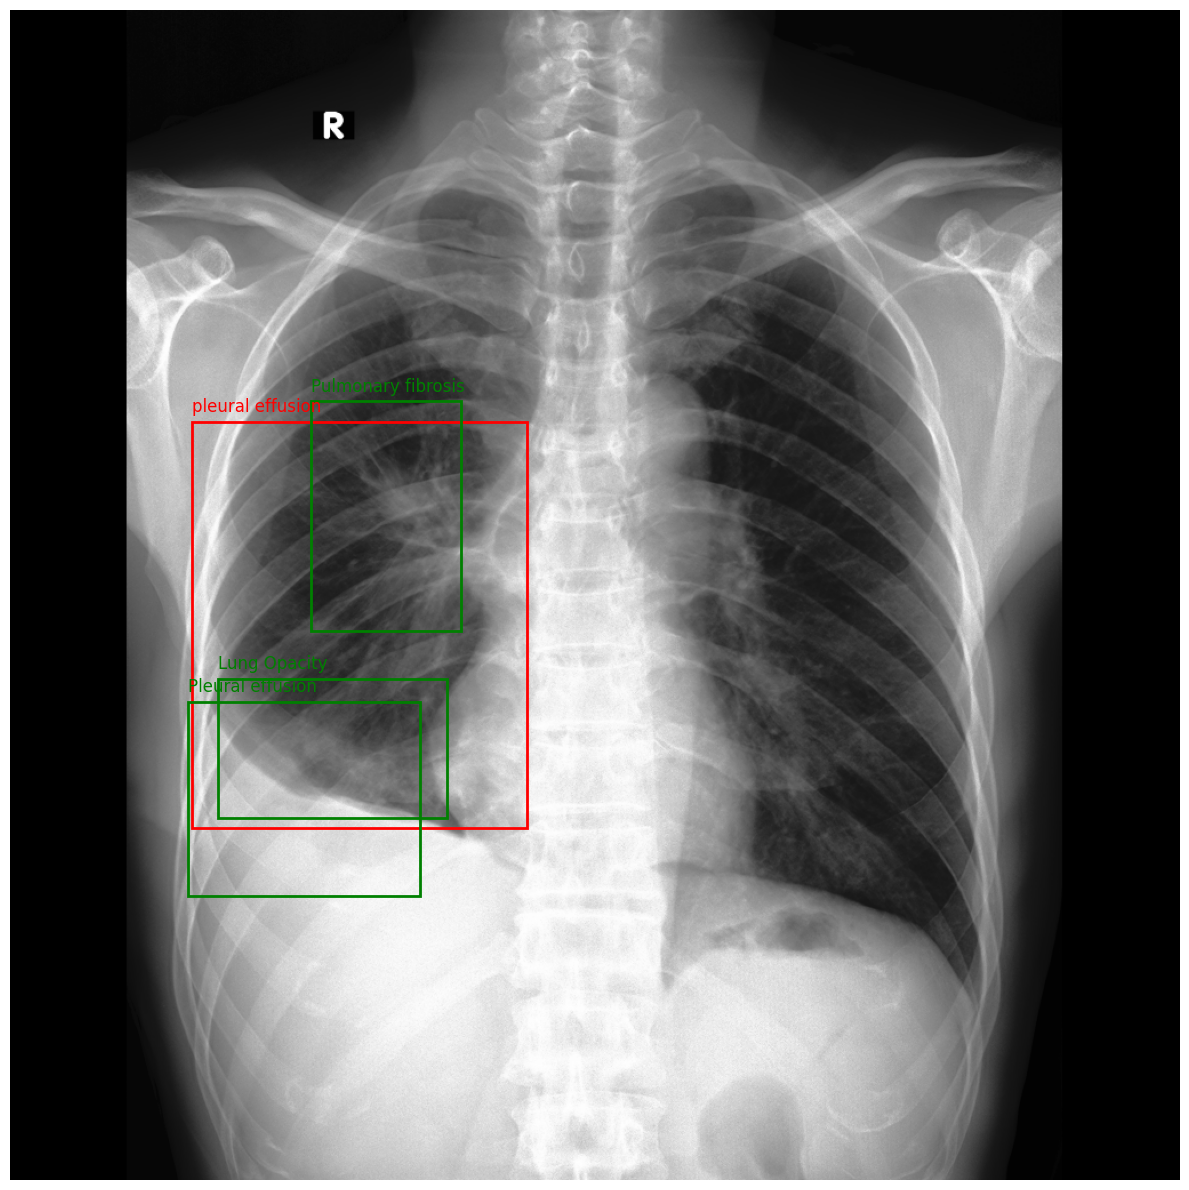

MeanAveragePrecisionResult:
Metric target: MetricTarget.BOXES
Class agnostic: False
mAP @ 50:95: 0.0000
mAP @ 50:    0.0000
mAP @ 75:    0.0000
mAP scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
AP per class:
  7: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  11: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  14: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Small objects:
  MeanAveragePrecisionResult:
  Metric target: MetricTarget.BOXES
  Class agnostic: False
  mAP @ 50:95: 0.0000
  mAP @ 50:    0.0000
  mAP @ 75:    0.0000
  mAP scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
  AP per class:
    No results
  
Medium objects:
  MeanAveragePrecisionResult:
  Metric target: MetricTarget.BOXES
  Class agnostic: False
  mAP @ 50:95: 0.0000
  mAP @ 50:    0.0000
  mAP @ 75:    0.0000
  mAP scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
  AP per class:
   

In [7]:
os.makedirs(CODEBASE_DIR / f"data/chest_xrays/comparison_images", exist_ok=True)

idx = 25

image_path = CODEBASE_DIR / f"data/chest_xrays/images/{annotations_list[idx]['imageID']}.png"
save_path = CODEBASE_DIR / f"data/chest_xrays/comparison_images/{annotations_list[idx]['imageID']}.png"

pred_boxes = annotations_list[idx]["detected_boxes"]
true_boxes = annotations_list[idx]["true_boxes"]

pred_classes = [disease_label_map[name.lower()] for name in annotations_list[idx]["detected_classes"]]
true_classes = [disease_label_map[name.lower()] for name in annotations_list[idx]["true_classes"]]

result = compute_map_supervision(pred_boxes, pred_classes, true_boxes, true_classes)
# draw_boxes(pred_boxes, true_boxes, image_size=(1024, 1024))
draw_boxes_on_image(
    image_path=image_path, 
    pred_boxes=pred_boxes, 
    true_boxes=true_boxes, 
    pred_labels=annotations_list[idx]["detected_classes"], 
    true_labels=annotations_list[idx]["true_classes"], 
    # save_path=save_path
)
print(result)

In [15]:
with open(classification_annotations_path, 'r') as file:
    classification_annotations = json.load(file)

gt = [value["status"] for _, value in true_annotations.items()]
pred = [ele["classification"] for ele in classification_annotations]

accuracy = accuracy_score(gt, pred)
f1 = f1_score(gt, pred, pos_label='unhealthy')

print(f"Accuracy: {accuracy:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.460
F1 Score: 0.426


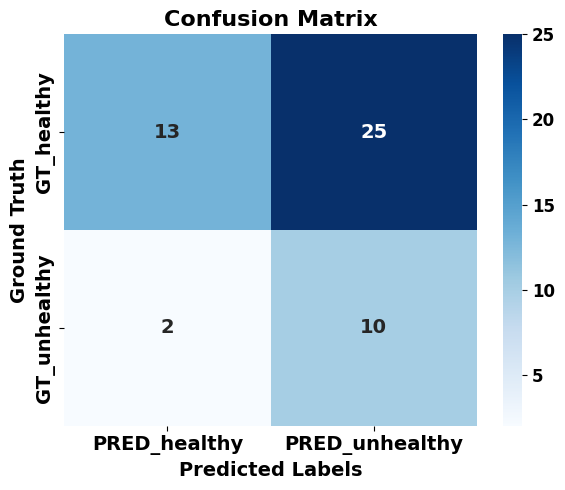

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Sample input
labels = ['healthy', 'unhealthy']
cm = confusion_matrix(gt, pred, labels=labels)

index_labels = ['GT_healthy', 'GT_unhealthy']
column_labels = ['PRED_healthy', 'PRED_unhealthy']
cm_df = pd.DataFrame(cm, index=index_labels, columns=column_labels)

heatmap = plt.figure(figsize=(6, 5))

heatmap = sns.heatmap(
    cm_df,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=True,
    annot_kws={"size": 14, "weight": "bold"}
)

plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
plt.ylabel('Ground Truth', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12)
for tick_label in colorbar.ax.get_yticklabels():
    tick_label.set_fontweight('bold')

plt.tight_layout()
plt.show()


# Brain MRI

In [28]:
true_annotations_mri_path = CODEBASE_DIR / "data/nova_brain/annotations.json"
detection_mri_annotations_path = CODEBASE_DIR / "data/nova_brain/detection_annotation_results.json"
caption_annotations_path = CODEBASE_DIR / "data/nova_brain/captions_results.json"

In [29]:
with open(true_annotations_mri_path, 'r') as file:
    true_annotations_mri = json.load(file)

with open(detection_mri_annotations_path, 'r') as file:
    detection_mri_annotations = json.load(file)

annotations_mri_list = []
for obj in detection_mri_annotations:
    id = obj["imageID"].split('_')[0]
    annotations_mri_list.append(
        {
            "imageID": obj["imageID"],
            "true_boxes": true_annotations_mri[id]["image_findings"][f"{obj['imageID']}.png"]["bbox_2d_gold"],
            "detected_boxes": [[ele["box_2d"][1], ele["box_2d"][0], ele["box_2d"][3], ele["box_2d"][2]] for ele in obj["annotation"]],
            "detected_classes": [ele["label"] for ele in obj["annotation"]]
        }
    )

In [30]:
# for Rodeo metrics
rodeo_annotations_mri_list = copy.deepcopy(annotations_mri_list)

for obj in rodeo_annotations_mri_list:
    if len(obj["true_boxes"])>0:
        for idx, ele in enumerate(obj["true_boxes"]):
            ele.append(0)
    else:
        obj["true_boxes"] = [[]]

    if len(obj["detected_boxes"])>0:
        for idx, ele in enumerate(obj["detected_boxes"]):
            ele.append(0)
    else:
        obj["detected_boxes"] = [[]]

In [35]:
rodeo_mri = RoDeO(class_names=["anomaly", "background"])

true_boxes = []
detected_boxes = []
for obj in rodeo_annotations_mri_list:
    tb = np.array(obj["true_boxes"], dtype=np.float32)
    db = np.array(obj["detected_boxes"], dtype=np.float32)
    tb = tb.reshape(-1, 5) if tb.size > 0 else np.empty((0, 5), dtype=np.float32)
    db = db.reshape(-1, 5) if db.size > 0 else np.empty((0, 5), dtype=np.float32)

    true_boxes.append(tb)
    detected_boxes.append(db)

rodeo_mri.add(detected_boxes, true_boxes)
score = rodeo_mri.compute()

for k, v in score.items():
    print(f"{k}: {v:.5f}")

RoDeO/localization: 0.37072
RoDeO/shape_matching: 0.28364
RoDeO/classification: 0.41473
RoDeO/total: 0.34745


In [50]:
os.makedirs(CODEBASE_DIR / f"data/nova_brain/comparison_images", exist_ok=True)

map50_95 = []
map50 = []
map75 = []
id = []

for idx in range(len(annotations_mri_list)):
    image_path = CODEBASE_DIR / f"data/nova_brain/images/{annotations_mri_list[idx]['imageID']}.png"
    save_path = CODEBASE_DIR / f"data/nova_brain/comparison_images/{annotations_mri_list[idx]['imageID']}.png"

    pred_boxes = annotations_mri_list[idx]["detected_boxes"]
    true_boxes = annotations_mri_list[idx]["true_boxes"]

    result = compute_map_supervision(pred_boxes, None, true_boxes, None)
    # draw_boxes(pred_boxes, true_boxes, image_size=(1024, 1024))
    draw_boxes_on_image(
        image_path=image_path, 
        pred_boxes=pred_boxes, 
        true_boxes=true_boxes, 
        save_path=save_path
    )

    annotations_mri_list[idx]["mAP@50:95:"] = result.map50_95
    annotations_mri_list[idx]["mAP@50:"] = result.map50
    annotations_mri_list[idx]["mAP@75:"] = result.map75

    map50_95.append(result.map50_95)
    map50.append(result.map50)
    map75.append(result.map75)
    id.append(annotations_mri_list[idx]['imageID'])

print(f"mAP@50:95: {(sum(map50_95) / len(map50_95)):.5f}")
print(f"mAP@50: {(sum(map50) / len(map50)):.5f}")
print(f"mAP@75: {(sum(map75) / len(map75)):.5f}")

mAP@50:95: 0.03380
mAP@50: 0.11903
mAP@75: 0.00549


In [51]:
combined = list(zip(map50_95, id))
combined_sorted = sorted(combined, key=lambda x: x[0], reverse=True)
map50_95_sorted, id_sorted = zip(*combined_sorted)

print(list(map50_95_sorted))
print(list(id_sorted)) 

[np.float64(0.4544554455445544), np.float64(0.39999999999999997), np.float64(0.39999999999999997), np.float64(0.39999999999999997), np.float64(0.29999999999999993), np.float64(0.29999999999999993), np.float64(0.19999999999999998), np.float64(0.19999999999999998), np.float64(0.19999999999999998), np.float64(0.09999999999999999), np.float64(0.09999999999999999), np.float64(0.03366336633663366), np.float64(0.02178217821782178), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64

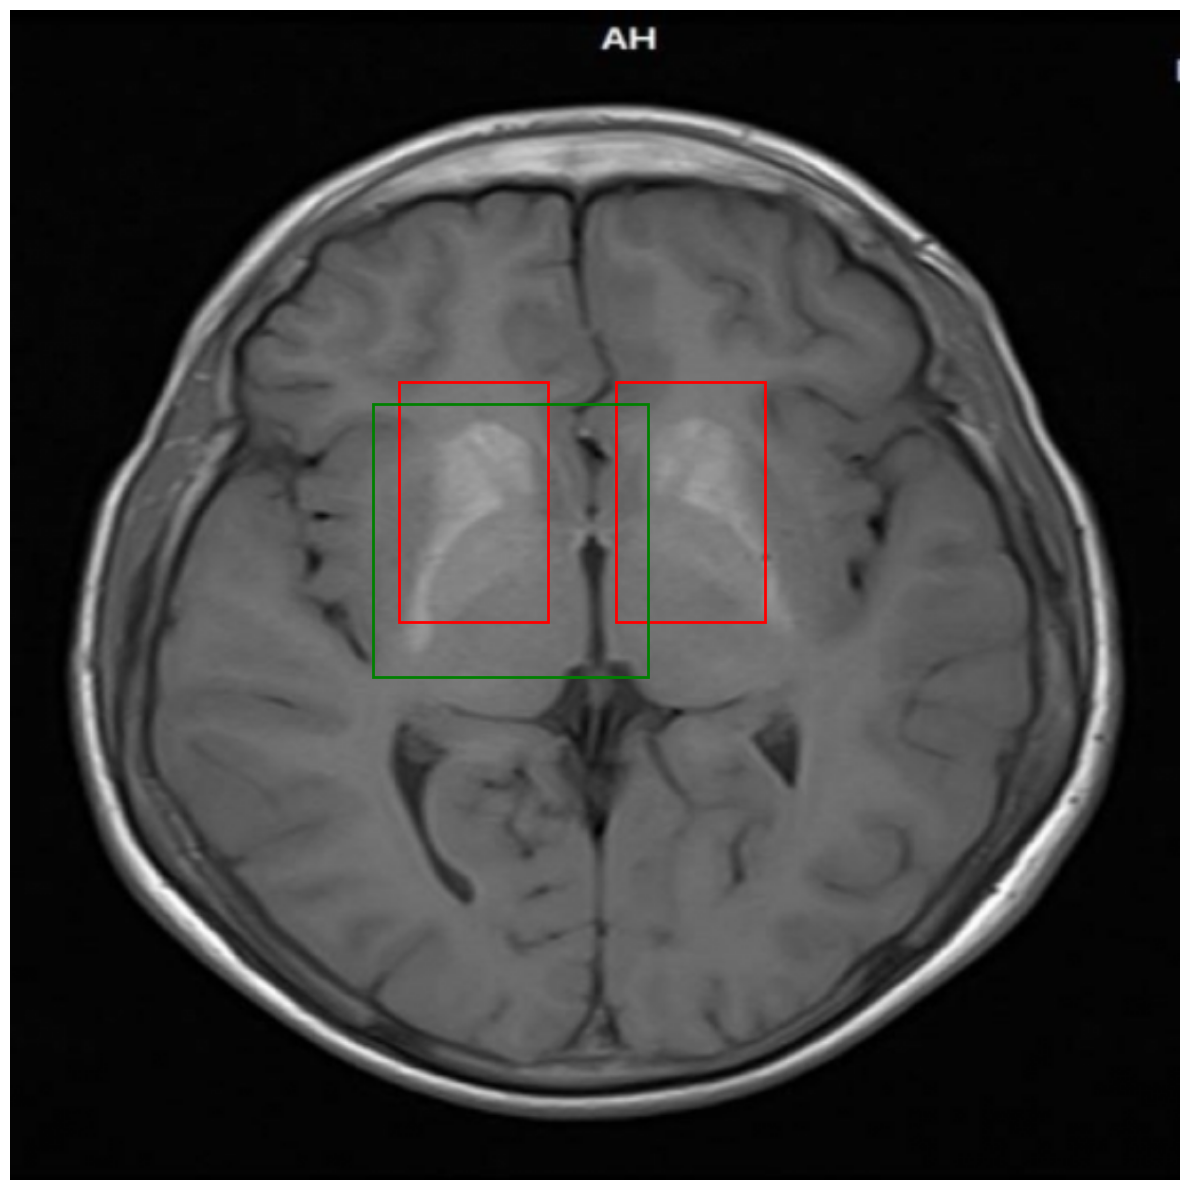

MeanAveragePrecisionResult:
Metric target: MetricTarget.BOXES
Class agnostic: False
mAP @ 50:95: 0.0000
mAP @ 50:    0.0000
mAP @ 75:    0.0000
mAP scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
AP per class:
  0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Small objects:
  MeanAveragePrecisionResult:
  Metric target: MetricTarget.BOXES
  Class agnostic: False
  mAP @ 50:95: 0.0000
  mAP @ 50:    0.0000
  mAP @ 75:    0.0000
  mAP scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
  AP per class:
    No results
  
Medium objects:
  MeanAveragePrecisionResult:
  Metric target: MetricTarget.BOXES
  Class agnostic: False
  mAP @ 50:95: 0.0000
  mAP @ 50:    0.0000
  mAP @ 75:    0.0000
  mAP scores: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
  AP per class:
    No results
  
Large objects:
  MeanAveragePrecisionResult:
  Metric target:

In [24]:
idx = 0
image_path = CODEBASE_DIR / f"data/nova_brain/images/{annotations_mri_list[idx]['imageID']}.png"

pred_boxes = annotations_mri_list[idx]["detected_boxes"]
true_boxes = annotations_mri_list[idx]["true_boxes"]

result = compute_map_supervision(pred_boxes, None, true_boxes, None)
# draw_boxes(pred_boxes, true_boxes, image_size=(1024, 1024))
draw_boxes_on_image(
    image_path=image_path, 
    pred_boxes=pred_boxes, 
    true_boxes=true_boxes
)

print(result)

In [87]:
with open(caption_annotations_path, 'r') as file:
    caption_mri_annotations = json.load(file)

mri_captions_list = []
for obj in caption_mri_annotations:
    id = obj["imageID"].split('_')[0]
    mri_captions_list.append(
        {
            "imageID": obj["imageID"],
            "true_caption": true_annotations_mri[id]["image_findings"][f"{obj['imageID']}.png"]["caption"],
            "predicted_caption": obj["caption"]
        }
    )

In [88]:
def calculate_similarity(text1, text2):
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    embedding1 = model.encode(text1, convert_to_tensor=True)
    embedding2 = model.encode(text2, convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embedding1, embedding2)

    return float(similarity.item())


In [89]:
# Gemini Flash 2.5
similarity_score_list = []

for obj in mri_captions_list:
    similarity_score = calculate_similarity(obj["true_caption"], obj["predicted_caption"])
    obj["similarity_score"] = similarity_score
    similarity_score_list.append(similarity_score)

print(f"Average Similarity Score: {(sum(similarity_score_list) / len(similarity_score_list)):.5f}")

HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/s

Average Similarity Score: 0.46644


In [90]:
import ast
import re

data_pd = pd.read_csv(CODEBASE_DIR / f"data/nova_brain/image_descriptions_finer.csv")

mri_captions_HuatuoGPT_vision_list = []
for idx in range(len(data_pd)):
    match = re.search(r'(case\d+_\d+)', data_pd.iloc[idx]['img_path'])
    sub_id_image = match.group(1)
    id_image = sub_id_image.split('_')[0]
    
    text = " ".join(ast.literal_eval(data_pd.iloc[idx]['output']))
    gt_text = true_annotations_mri[id_image]["image_findings"][f"{sub_id_image}.png"]["caption"]

    mri_captions_HuatuoGPT_vision_list.append(
        {
            "imageID": sub_id_image,
            "true_caption": gt_text,
            "predicted_caption": text
        }
    )

similarity_score_HuatuoGPT_vision_list = []
for obj in mri_captions_HuatuoGPT_vision_list:
    similarity_score = calculate_similarity(obj["true_caption"], obj["predicted_caption"])
    obj["similarity_score"] = similarity_score
    similarity_score_HuatuoGPT_vision_list.append(similarity_score)

HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/s

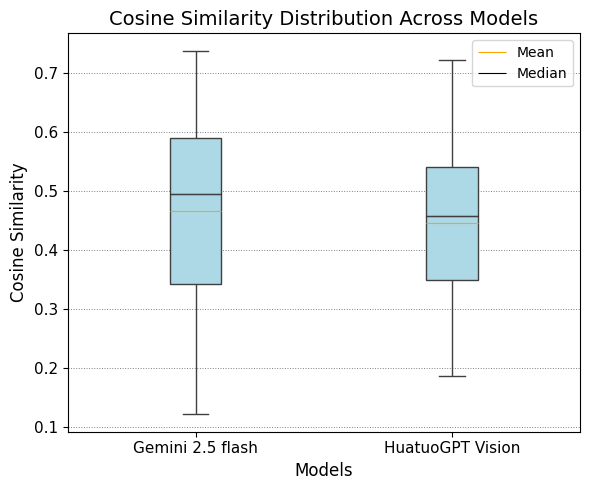

In [135]:
df = pd.DataFrame({
    'Gemini 2.5 flash': similarity_score_list,
    'HuatuoGPT Vision': similarity_score_HuatuoGPT_vision_list
})
df_melted = df.melt(var_name='Models', value_name='Cosine Similarity')

plt.figure(figsize=(6, 5))
ax = sns.boxplot(
    data=df_melted,
    x='Models',
    y='Cosine Similarity',
    width=0.2,
    showcaps=True,
    boxprops={'facecolor': 'lightblue'},
    showfliers=False
)

plt.grid(True, linestyle=':', linewidth=0.7, color='gray', axis='y')

means = df_melted.groupby('Models')['Cosine Similarity'].mean()
medians = df_melted.groupby('Models')['Cosine Similarity'].median()

for i, model in enumerate(means.index):
    ax.hlines(means[model], i - 0.1, i + 0.1, colors='orange', linewidth=0.8, label='Mean' if i == 0 else "")
    ax.hlines(medians[model], i - 0.1, i + 0.1, colors='black', linewidth=0.8, label='Median' if i == 0 else "")

plt.legend()
plt.title('Cosine Similarity Distribution Across Models', fontsize=14)
plt.xlabel('Models', fontsize=12)
ax.set_xlim(-0.5, len(means) - 0.5)
plt.ylabel('Cosine Similarity', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [11]:
mri_captions_list[0]

{'imageID': 'case0005_001',
 'true_boxes': 'T1 hyperintense signals in bilateral basal ganglia',
 'predicted_caption': 'The provided image is an axial view of a T1-weighted brain MRI. The cortical sulci appear well-defined, and the gray-white matter differentiation is preserved. There are bilateral, symmetric, T1 hyperintense lesions noted in the globus pallidus of the basal ganglia. The ventricles and other intracranial structures appear unremarkable. No evidence of significant mass effect or hydrocephalus is observed.',
 'similarity_score': 0.639211893081665}

In [12]:
with open(CODEBASE_DIR / f"data/nova_brain/caption_with_similarity.json", "w") as file:
    json.dump(mri_captions_list, file)